# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

**ТЗ**

- Изучить файл с телефонными тарифами и создать модель для рекомендации тарифа
- Рассмотреть несколько моделей для решения задачи бинарной классификации
- Деревья решений, Случайный лес, Логистическую регрессиию
- Подобрать гиперпараметры моделей
- На основе метрики accuracy оценить качество модели
- Общий вывод

**Описание данных**

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='whitegrid')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv', encoding='UTF-8')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.shape

(3214, 5)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


In [5]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


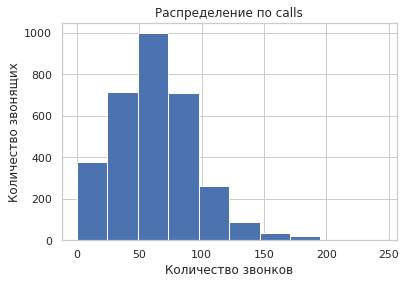

In [7]:
plt.hist(df['calls'], bins=10)
plt.title('Распределение по calls')
plt.ylabel('Количество звонящих')
plt.xlabel('Количество звонков')
plt.grid(True)
plt.show()

**Вывод**

В основном, пользователи совершают 30-70 звонков в месяц. Очень редки случаи на 100+ звонков

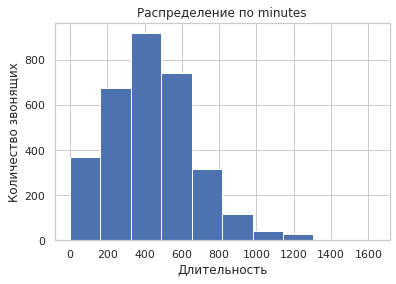

In [8]:
plt.hist(df['minutes'], bins=10)
plt.title('Распределение по minutes')
plt.ylabel('Количество звонящих')
plt.xlabel('Длительность')
plt.grid(True)
plt.show()

**Вывод**

Большинство пользователей расходует 200-600 минут в месяц

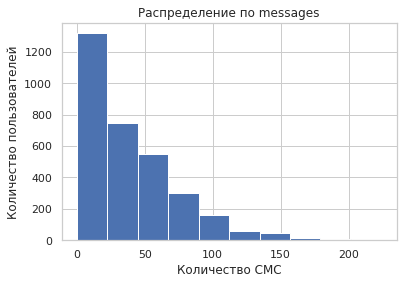

In [9]:
plt.hist(df['messages'], bins=10)
plt.title('Распределение по messages')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество СМС')
plt.grid(True)
plt.show()

**Вывод**

СМС не пользуются особой популярностью. Возможно, это связано с устареванием технологии и доступностю мессенджеров. Проверим это далее

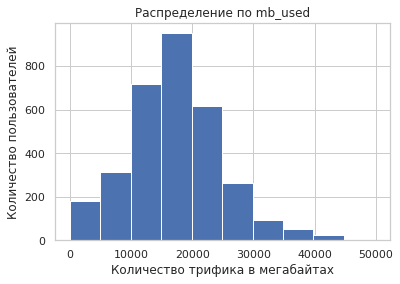

In [10]:
plt.hist(df['mb_used'], bins=10)
plt.title('Распределение по mb_used')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество трифика в мегабайтах')
plt.grid(True)
plt.show()

Действительно, в основном, пользователи расходуют 15000-25000 Мб интернета в месяц, вероятно, на соцсети, что объясняет низкую популярность СМС

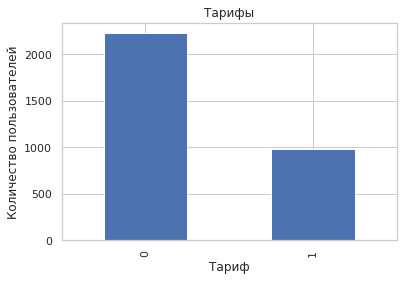

In [11]:
tarif = df['is_ultra'].value_counts()
tarif.plot.bar()
plt.title('Тарифы')
plt.ylabel('Количество пользователей')
plt.xlabel('Тариф')
plt.grid(True)
plt.show()

**Вывод**

Тарифом Ультра пользуются значительно меньше (разница более, чем в 2 раза)

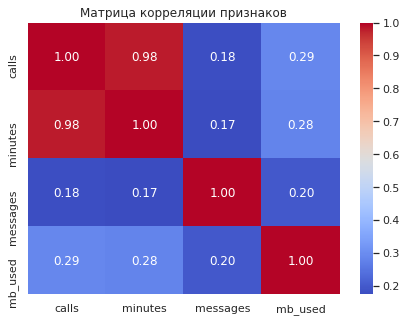

In [12]:
# Хочу посмотреть корреляцию между признаками
# is_ultra удалил, потому что это категориальный признак и корреялция Пирсона не применима к нему
corr_matrix = df.drop('is_ultra', axis=1).corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции признаков')
plt.show()

**Вывод**

- Слабая корреляция между пользованием интернетом и СМС
- Сильная корреляция между количеством звонков и минутами
- Слабая корреляция между звонками и пользованием интернетом, аналогично с минутами

**Вывод по разделу**

Мы открыли датасет и изучили основную информацию в нём посредством методов Pandas и визуализации

## Разбейте данные на выборки

In [13]:
# Делим датасет на 3 выборки: обучающую, валидационную и тестовую в соотношении 2:1:1
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

X, X_test, y, y_test = train_test_split(features, 
                                        target, 
                                        random_state=12345, 
                                        test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  random_state=12345,
                                                  test_size=0.3333) #0.25 от общего числа

In [14]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}\n'
      f'X_val: {X_val.shape}, y_val: {y_val.shape}\n'
      f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (1606, 4), y_train: (1606,)
X_val: (804, 4), y_val: (804,)
X_test: (804, 4), y_test: (804,)


## Исследуйте модели

In [15]:
model_regression = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)

model_regression.fit(X_train, y_train)
y_pred = model_regression.predict(X_val)
accuracy_reg = accuracy_score(y_val, y_pred)
accuracy_reg

0.7375621890547264

**Вывод**

Реграссия показывает неплохой результат, однако, модель всё ещё нуждается в доработке

In [16]:
acc = {}

for depth in range(1, 6):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth,
                                        criterion='gini')
    model_tree.fit(X_train, y_train)
    y_pred_tree = model_tree.predict(X_val)
    accuracy_tree = accuracy_score(y_val, y_pred_tree)
    acc.update({depth:accuracy_tree})

acc

{1: 0.7437810945273632,
 2: 0.7699004975124378,
 3: 0.7873134328358209,
 4: 0.7810945273631841,
 5: 0.7798507462686567}

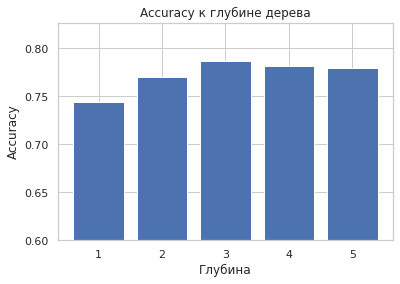

In [17]:
plt.bar(list(acc.keys()), list(acc.values()))
plt.ylim(bottom=0.6)
plt.title('Accuracy к глубине дерева')
plt.xlabel('Глубина')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [18]:
'''model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=3,
                                        criterion='gini')
    model_tree.fit(X_train, y_train)
    y_pred_tree = model_tree.predict(X_val)
    accuracy_tree = accuracy_score(y_val, y_pred_tree'''

"model_tree = DecisionTreeClassifier(random_state=12345,\n                                        max_depth=3,\n                                        criterion='gini')\n    model_tree.fit(X_train, y_train)\n    y_pred_tree = model_tree.predict(X_val)\n    accuracy_tree = accuracy_score(y_val, y_pred_tree"

**Вывод**

Дерево решений показывает результат лучше, чем логистическая регрессия. При глубине дерева = 3, accuracy достигает 0.787

In [19]:
acc_matrix = pd.DataFrame(columns=['Max Depth', 'n_estimators', 'Accuracy'])

for depth in range(1, 6):
    for est in range(1, 6):
        model_forest = RandomForestClassifier(random_state=12345,
                                              max_depth=depth,
                                              n_estimators=est)
        model_forest.fit(X_train, y_train)
        y_tree_forest = model_forest.predict(X_val)
        accuracy_forest = accuracy_score(y_val, y_tree_forest)
        
        acc_matrix = acc_matrix.append({'Max Depth': depth, 
                                        'n_estimators': est, 
                                        'Accuracy': accuracy_forest}, 
                                        ignore_index=True)
        
acc_matrix

,Max Depth,n_estimators,Accuracy
0,1.0,1.0,0.730100
1,1.0,2.0,0.730100
2,1.0,3.0,0.730100
3,1.0,4.0,0.730100
4,1.0,5.0,0.728856
5,2.0,1.0,0.771144
6,2.0,2.0,0.772388
7,2.0,3.0,0.771144
8,2.0,4.0,0.779851
9,2.0,5.0,0.745025


In [20]:
acc_matrix.loc[acc_matrix['Accuracy'].idxmax()]

Max Depth       5.000000
n_estimators    4.000000
Accuracy        0.793532
Name: 23, dtype: float64

**Вывод**

Случайный лес показывает лучший результат: 0.793 при глубине 5 и количестве деревьев 4. Однако, стоить поминть, что большая модель склонна к переобучению, поэтому стоит её проверить.

## Проверьте модель на тестовой выборке

Мы выяснили, что лучший результат показывает Случайный Лес с глубиной 5 и количетсвом деревьев 4. Значит, построим модель с аналогичными геперпараметрами и проверим качество модели уже на тестовой выборке, а не на валидационной.

Если accuracy на валидационной выборке больше, что модель переобучилась

In [21]:
model_forest = RandomForestClassifier(random_state=12345,
                                              max_depth=5,
                                              n_estimators=4)
model_forest.fit(X_train, y_train)

test_prediction_forest = model_forest.predict(X_test)
accuracy_test_forest = accuracy_score(y_test, test_prediction_forest)
accuracy_test_forest

0.7935323383084577

**Вывод**

Accuracy на тестовой выборке получиось аналогичным получившемуся на валидационной выборке. Это значит, что модель не переобучилась и имеет хорошее качество.

**Предсказание на новых данных**

Напишем функцию, которая будет принимать модель и X.
Функция формирует из параметров X двухмерный массив, так как для регрессии в sklearn используется множественная регрессия и на вход должен подаваться двухмерный массив.

In [22]:
def prediction(model, calls, minutes, messages, mb_used):
    features = np.array([calls, minutes, messages, mb_used]).reshape(1, -1)
    prediction = model.predict(features)
    return prediction

In [23]:
prediction(model_forest, 300, 600, 120, 2000)

array([1])

In [24]:
prediction(model_forest, 120, 200, 60, 2000)

array([0])

In [25]:
prediction(model_forest, 120, 300, 50, 20000)

array([0])

## (бонус) Проверьте модели на адекватность

Чтобы проверить адекватность моделей, воспользуемся методом кросс-валидации

In [26]:
regression_cross_val = cross_val_score(model_regression, X_train, y_train, cv=10)
tree_cross_val = cross_val_score(model_tree, X_train, y_train, cv=10)
forest_cross_val = cross_val_score(model_forest, X_train, y_train, cv=10)

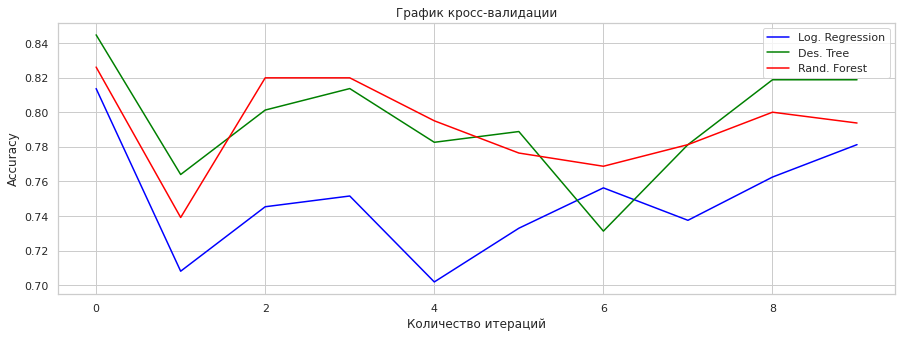

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(regression_cross_val, color='blue')
plt.plot(tree_cross_val, color='green')
plt.plot(forest_cross_val, color='red')
plt.title('График кросс-валидации')
plt.xlabel('Количество итераций')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Log. Regression', 'Des. Tree', 'Rand. Forest'])
plt.show()

**Вывод**

Говоря об адекватности моделей, меня несколько смущает, что они начинают обучаться с accuracy уже около 0.8. 

**Общий вывод**

- Нами были изучены данные о пользователях мобильных тарифов. Целью исследование стояло создание алгоритма предсказания рекомендации тарифа пользователю по его параметрам. 
- В качестве моделей, решиющих задачу бинарной классификации рассматривались логистическая регрессия, дерево решений и случайный лес.
- В ходе сравления моделей предпочтение было отдано третьей модели. Далее модель проверялась на тестовой выборке на предмет переобучения.
- Для выбранной модели была написана функция, которая предсказывает класс 0 или 1 на новых данных, поступающих в неё.
- На основе предсказаний на новых данных, мы получили, что человек, совершающий 300 звонков в месяц, расходуя 600 минут, отпраавляя 120 сообщений и расходуя 2000 мб интернета, скорее всего, буджет использовать тариф Ультра. Пользователь с одноимёнными параметрами: 120, 300, 50, 20000, скорее всего, не будет.
- Был построен график кросс-валидации для проверки адекватности моделей, как дополнительное задание.
